# 손글씨 숫자 인식 가중치 학습

In [1]:
import tensorflow as tf
import numpy as np

## ReLU 정의
$
ReLU(x) = \begin{cases} 
    0 & (x \leq 0) \\ 
    x & (x > 0)
\end{cases}
$

**forwarding**

$ReLU(x)$

**backwarding**

$
\frac{\partial ReLu(x)}{\partial x} = \begin{cases}
    \frac{\partial 0}{\partial x} = 0 & (x \leq 0) \\
    \frac{\partial x}{\partial x} = 1& (x > 0)
\end{cases}
$

In [2]:
class ReLU:
    def __init__(self):
        self.disabled: np.ndarray = None

    def forward(self, x) -> np.ndarray:
        self.disabled = (x <= 0)
        out = x.copy()
        out[self.disabled] = 0
        return out

    def backward(self, dout) -> np.ndarray:
        dout[self.disabled] = 0
        dx: np.ndarray = dout
        return dx

## Sigmoid 정의

$
\sigma(x) = \frac{1}{1 + e^{-x}} = \frac{e^x}{1 + e^x} = 1 - \sigma(-x)
$

**forwarding**

$
\sigma(x)
$

**backwarding**

$
\frac{\partial \sigma(x)}{\partial x} = \sigma(x) \times (1 - \sigma(x))
$

In [3]:
class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = 1 / (1+np.exp(-x))
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx

## Affine

$
A(X) = XW + B
$

**forwarding**

$
A(X)
$

**backwarding**

1. ${X \cdot Y}$ side: $\frac{\partial L}{\partial Y}$
    1. $X$ side: $\frac{\partial Loss}{\partial X} = \frac{\partial Loss}{\partial Y} \cdot {W}$
    2. $W$ side: $\frac{\partial Loss}{\partial W} = X^\intercal \cdot \frac{\partial Loss}{\partial Y}$
2. $B$ side: $\frac{\partial L}{\partial Y}$

In [4]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b

        self.x = None
        self.original_x_shape = None
        # 가중치와 편향 매개변수의 미분
        self.dW = None
        self.db = None

    def forward(self, x):
        # 텐서 대응
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        # 입력 데이터 모양 변경(텐서 대응)
        dx = dx.reshape(*self.original_x_shape)
        return dx

## Softmax

$
y_k = \frac{exp(a_k)}{\sum^{n}_{i = 1} exp(a_i)}
$

In [5]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T
    x = x - np.max(x) # Prevent overflow
    return np.exp(x) / np.sum(np.exp(x))

## Cross Entropy Error

$
E = - \sum^{i}_{k = 1}t_k log_e y_k
$

In [6]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

## Softmax + Loss

In [7]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None    # softmax의 출력
        self.t = None    # 정답 레이블(원-핫 인코딩 형태)

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 정답 레이블이 원-핫 인코딩 형태일 때
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        return dx

## Network Component (2-Layer)

In [8]:
from collections import OrderedDict
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = ReLU()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def gradient(self, x, t):
        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        return grads

In [9]:
import time
import matplotlib.pyplot as plt
# 데이터 준비
(x_train, t_train), (x_test, t_test) = tf.keras.datasets.mnist.load_data()

# 네트워크 생성
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 하이퍼파라미터
iters_num = 10000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

start = time.time()
for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 순전파
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    # 역전파: 기울기 계산
    grad = network.gradient(x_batch, t_batch)

    # 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]


    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))
end = time.time()

# 연산시간 출력
print("연산 시간: {}".format(end - start))


train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.11236666666666667, 0.1135
연산 시간: 41.211004972457886


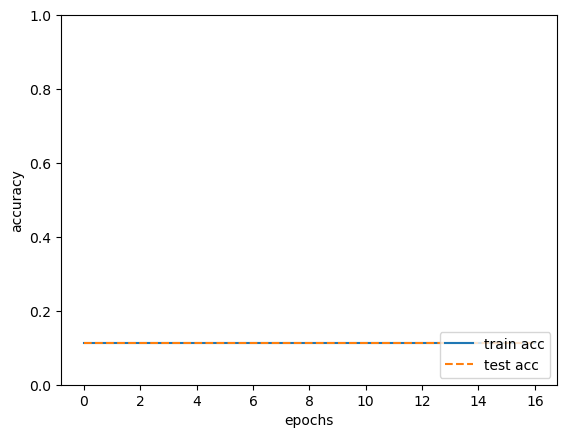

In [10]:

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

Answer:  1


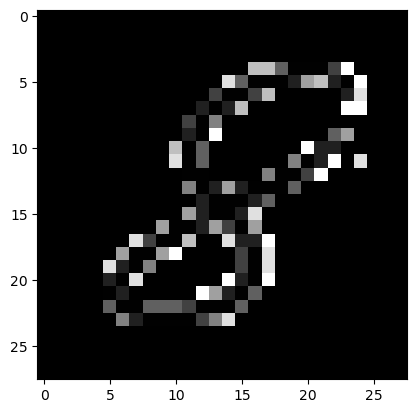

In [11]:
from matplotlib.pyplot import imshow
%matplotlib inline

sample_mask = np.random.choice(x_test.shape[0], 1)
x_sample = x_test[sample_mask]
t_sample = t_test[sample_mask]

img = x_sample * np.iinfo(np.uint8).max
img = img.reshape(28, 28)
imshow(np.uint8(img), cmap='gray')

# Prediction
y_pred = network.predict(x_sample)
y = np.argmax(y_pred)
print("Answer: ", y)